<a href="https://colab.research.google.com/github/absallh/selected_1/blob/master/selected_linear_dateset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download the dataset form kaggle

In [ ]:
#set up kaggle
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#download the dataset
!kaggle datasets download -d henriqueyamahata/bank-marketing
!unzip bank-marketing; rm -v bank-marketing.zip

  0% 0.00/393k [00:00<?, ?B/s]
100% 393k/393k [00:00<00:00, 57.2MB/s]
Archive:  bank-marketing.zip
replace bank-additional-full.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
removed 'bank-marketing.zip'


#Loading and Displaying data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.svm import SVC
from sklearn import metrics
from statistics import mean
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve

In [ ]:
pd.set_option('display.max_columns', None)
#load dataset
df = pd.read_csv("bank-additional-full.csv", sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.shape

(41188, 21)

In [ ]:
# Appearing data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#preprocessing

In [ ]:
#get the names of catagorical classes and numerical classes
var_categorical = list(set(df.columns) - set(df._get_numeric_data().columns))
var_numerical = list(df._get_numeric_data().columns)
var_categorical = list(set(var_categorical) - set('y'))
print(len(var_categorical), len(var_numerical))

10 10


##messing values

In [ ]:
#make the unknown null to make it identifiable
df.replace('unknown', np.NaN, inplace=True)

In [ ]:
df.isnull().sum()/len(df)*100

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

In [ ]:
# Number of distinct values in variables
for i, column in enumerate(df.columns):
    print("{}. ".format(i) + str(column.title()) + ": {}". format(df[column].nunique()))

0. Age: 78
1. Job: 11
2. Marital: 3
3. Education: 7
4. Default: 2
5. Housing: 2
6. Loan: 2
7. Contact: 2
8. Month: 10
9. Day_Of_Week: 5
10. Duration: 1544
11. Campaign: 42
12. Pdays: 27
13. Previous: 8
14. Poutcome: 3
15. Emp.Var.Rate: 10
16. Cons.Price.Idx: 26
17. Cons.Conf.Idx: 26
18. Euribor3M: 316
19. Nr.Employed: 11
20. Y: 2


In [ ]:
# Default variable has 20% messing values.
df.drop(["default"], axis = 1, inplace=True)
var_categorical = list(set(var_categorical) - set(['default']))

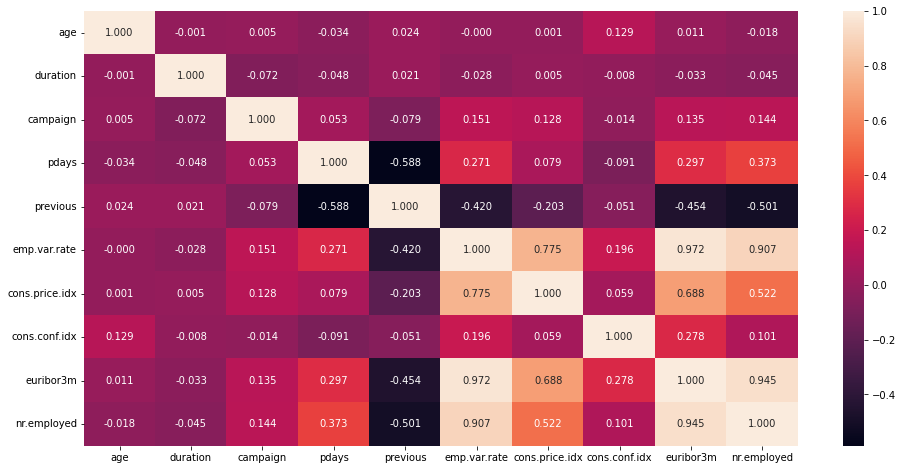

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt='.3f')

In [ ]:
#drop highly correlated variables
df.drop(['emp.var.rate', 'nr.employed'], axis = 1, inplace=True)
var_numerical = list(set(var_numerical) - set(['emp.var.rate', 'nr.employed']))

Pdays


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


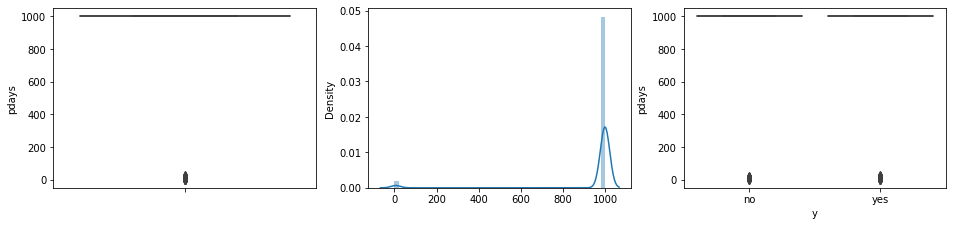

Duration


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


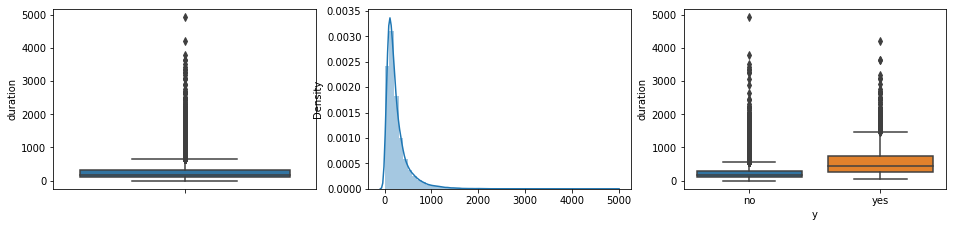

Cons.Conf.Idx


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


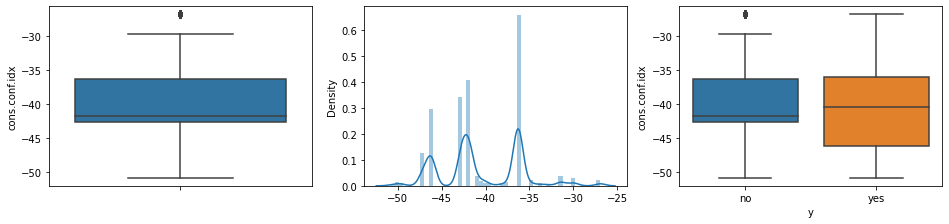

Campaign


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


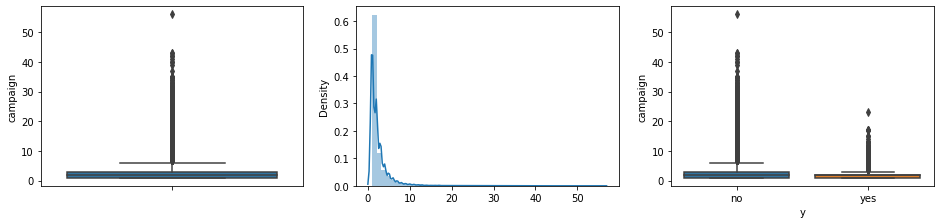

Age


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


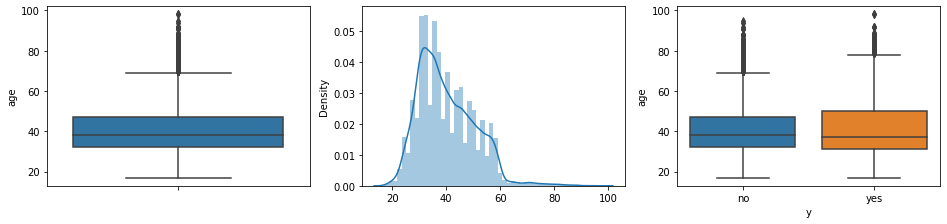

Cons.Price.Idx


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


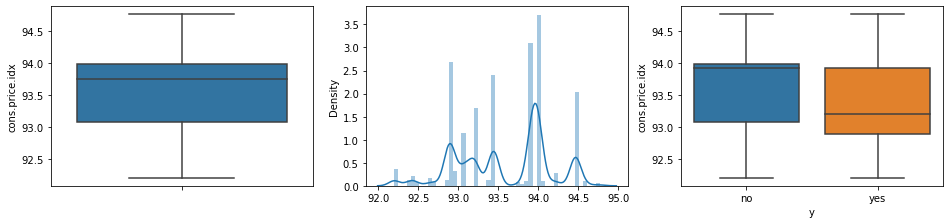

Previous


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


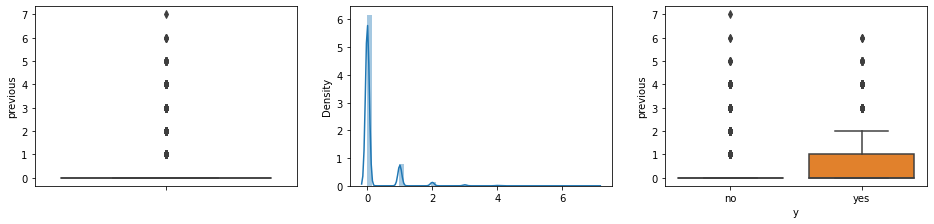

Euribor3M


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


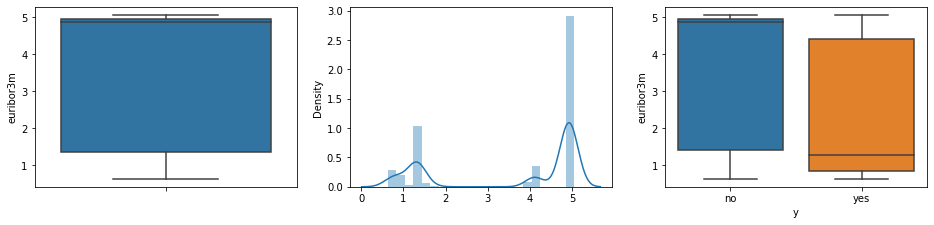

In [ ]:
#show numerical data
i = 1
for column in var_numerical:
    print(column.title())
    plt.subplots(figsize=(16, 35))
    plt.subplot(len(var_numerical) + 1, 3, i)
    sns.boxplot(y = df[column])
    i += 1
    plt.subplot(len(var_numerical) + 1, 3, i)
    sns.distplot(x = df[column])
    i += 1
    plt.subplot(len(var_numerical) + 1, 3, i)
    sns.boxplot(x = df["y"], y = df[column])
    i += 1
    plt.show()

In [ ]:
df[var_numerical].describe()

,pdays,duration,cons.conf.idx,campaign,age,cons.price.idx,previous,euribor3m
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.00000,41188.000000,41188.000000,41188.000000
mean,962.475454,258.285010,-40.502600,2.567593,40.02406,93.575664,0.172963,3.621291
std,186.910907,259.279249,4.628198,2.770014,10.42125,0.578840,0.494901,1.734447
min,0.000000,0.000000,-50.800000,1.000000,17.00000,92.201000,0.000000,0.634000
25%,999.000000,102.000000,-42.700000,1.000000,32.00000,93.075000,0.000000,1.344000
50%,999.000000,180.000000,-41.800000,2.000000,38.00000,93.749000,0.000000,4.857000
75%,999.000000,319.000000,-36.400000,3.000000,47.00000,93.994000,0.000000,4.961000
max,999.000000,4918.000000,-26.900000,56.000000,98.00000,94.767000,7.000000,5.045000


##we will handel  'campaign', 'age', 'previous', 'cons.conf.idx', 'pdays'

campaign

In [ ]:
print(df["campaign"].quantile(0.05), len(df[df["campaign"]<df["campaign"].quantile(0.05)] ))
print(df["campaign"].quantile(0.95), len(df[df["campaign"]>df["campaign"].quantile(0.95)] ))

1.0 0
7.0 1777


In [ ]:
df1 = df[(df["campaign"] > 23) & (df["y"] == 'yes')]
len(df1[['campaign', 'y']])

0

In [ ]:
df1 = df[(df["campaign"] > 8) & (df["y"] == 'yes')]
print(len(df1[['campaign', 'y']]), len(df[df["campaign"]>8]))

56 1377


In [ ]:
# We will convert all the values above 8 in campaign to 8
df["campaign"] = df["campaign"].apply(lambda x: 8 if x > 8 else x)

age

In [ ]:
print(df["age"].quantile(0.05), len(df[df["age"]<df["age"].quantile(0.05)] ))
print(df["age"].quantile(0.95), len(df[df["age"]>df["age"].quantile(0.95)] ))

26.0 1666
58.0 1656


previous

In [ ]:
print(df["previous"].quantile(0.05), len(df[df["previous"]<df["previous"].quantile(0.05)] ))
print(df["previous"].quantile(0.95), len(df[df["previous"]>2] ))

0.0 0
1.0 310


In [ ]:
for i in range(1, max(df["previous"])+1):
    print(i, end = " ")
    df1 = df[(df["previous"] >= i) & (df["y"] == 'yes')]
    print(len(df1[['previous', 'y']]), len(df[df["previous"]>= i]))

1 1499 5625
2 532 1064
3 182 310
4 54 94
5 16 24
6 3 6
7 0 1


In [ ]:
# We will convert all the values above 2 in previous to 2
df["previous"] = df["previous"].apply(lambda x: 2 if x >= 2 else x)

pdays

In [ ]:
print(df["pdays"].quantile(0.05), len(df[df["pdays"]<df["pdays"].quantile(0.05)] ))
print(df["pdays"].quantile(0.95), len(df[df["pdays"]>df["pdays"].quantile(0.95)] ))

999.0 1515
999.0 0


In [ ]:
df1 = df[(df["pdays"] >= 999) & (df["y"] == 'yes')]
print(len(df1[['pdays', 'y']]), len(df[df["pdays"]>=999]))
df1 = df[(df["pdays"] < 999) & (df["y"] == 'yes')]
print(len(df1[['pdays', 'y']]), len(df[df["pdays"]<999]))

df1 = df[(df["pdays"] < 28) & (df["y"] == 'yes')]
print(len(df1[['pdays', 'y']]), len(df[df["pdays"]<28]))

df1 = df[(df["pdays"] < 10) & (df["y"] == 'yes')]
print(len(df1[['pdays', 'y']]), len(df[df["pdays"]<10]))

3673 39673
967 1515
967 1515
821 1259


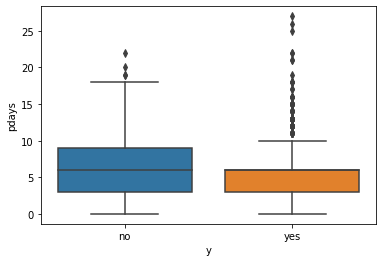

In [ ]:
# Look into the pdays values which are less than 999
df1 = df[~(df["pdays"] >= 999)]
sns.boxplot(x = df1["y"], y = df1['pdays'])
plt.show()

In [ ]:
print(len(var_categorical), var_categorical)
print(len(var_numerical), var_numerical)

9 ['contact', 'housing', 'day_of_week', 'loan', 'marital', 'month', 'poutcome', 'education', 'job']
8 ['pdays', 'duration', 'cons.conf.idx', 'campaign', 'age', 'cons.price.idx', 'previous', 'euribor3m']


In [ ]:
df.isnull().sum()/len(df)*100

age               0.000000
job               0.801204
marital           0.194231
education         4.202680
housing           2.403613
loan              2.403613
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
y                 0.000000
dtype: float64

##catagorical values

In [ ]:
print(df["loan"].value_counts())
print(df["housing"].value_counts())
print(df["contact"].value_counts())
print(df["y"].value_counts())

no     33950
yes     6248
Name: loan, dtype: int64
yes    21576
no     18622
Name: housing, dtype: int64
cellular     26144
telephone    15044
Name: contact, dtype: int64
no     36548
yes     4640
Name: y, dtype: int64


In [ ]:
varlist = ['loan', 'housing', 'y']

df[varlist] = df[varlist].apply(lambda x: x.map({'yes':1, 'no': 0}))

###One Hot Encoding for categorical variables

In [ ]:
print(len(var_categorical), var_categorical)
print(len(var_numerical), var_numerical)

9 ['contact', 'housing', 'day_of_week', 'loan', 'marital', 'month', 'poutcome', 'education', 'job']
8 ['pdays', 'duration', 'cons.conf.idx', 'campaign', 'age', 'cons.price.idx', 'previous', 'euribor3m']


In [ ]:
# Get the dummy variables for contact, poutcome , job, month, marital, day_of_week, education
# Let's drop the first column from  using 'drop_first = True' as first column can be derived using other columns 
# drop day of week feature (dropping redundant column)

contact = pd.get_dummies(df.contact, drop_first=True)
poutcome = pd.get_dummies(df.poutcome, drop_first=True)
job = pd.get_dummies(df.job, drop_first=True)
month = pd.get_dummies(df.month, drop_first=True)
marital = pd.get_dummies(df.marital, drop_first=True)
day_of_week = pd.get_dummies(df.day_of_week, drop_first=True)
education = pd.get_dummies(df.education, drop_first=True)

In [ ]:
# Concat the dummy columns to the dataframe
df = pd.concat([df, contact, poutcome , job, month, marital, day_of_week, education], axis=1)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y,telephone,nonexistent,success,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,aug,dec,jul,jun,mar,may,nov,oct,sep,married,single,mon,thu,tue,wed,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree
0,56,housemaid,married,basic.4y,0.0,0.0,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,57,services,married,high.school,0.0,0.0,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,37,services,married,high.school,1.0,0.0,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,40,admin.,married,basic.6y,0.0,0.0,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,56,services,married,high.school,0.0,1.0,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
# Dropping contact, poutcome , job, month, marital, day_of_week, education as we have concatenated the dummies in our original dataframe
df.drop(var_categorical, axis = 1, inplace = True)
df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,y,telephone,nonexistent,success,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,aug,dec,jul,jun,mar,may,nov,oct,sep,married,single,mon,thu,tue,wed,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree
0,56,261,1,999,0,93.994,-36.4,4.857,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,57,149,1,999,0,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,37,226,1,999,0,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,40,151,1,999,0,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,56,307,1,999,0,93.994,-36.4,4.857,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
df.columns, len(df.columns)

(Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'y', 'telephone', 'nonexistent',
        'success', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
        'sep', 'married', 'single', 'mon', 'thu', 'tue', 'wed', 'basic.6y',
        'basic.9y', 'high.school', 'illiterate', 'professional.course',
        'university.degree'],
       dtype='object'), 43)

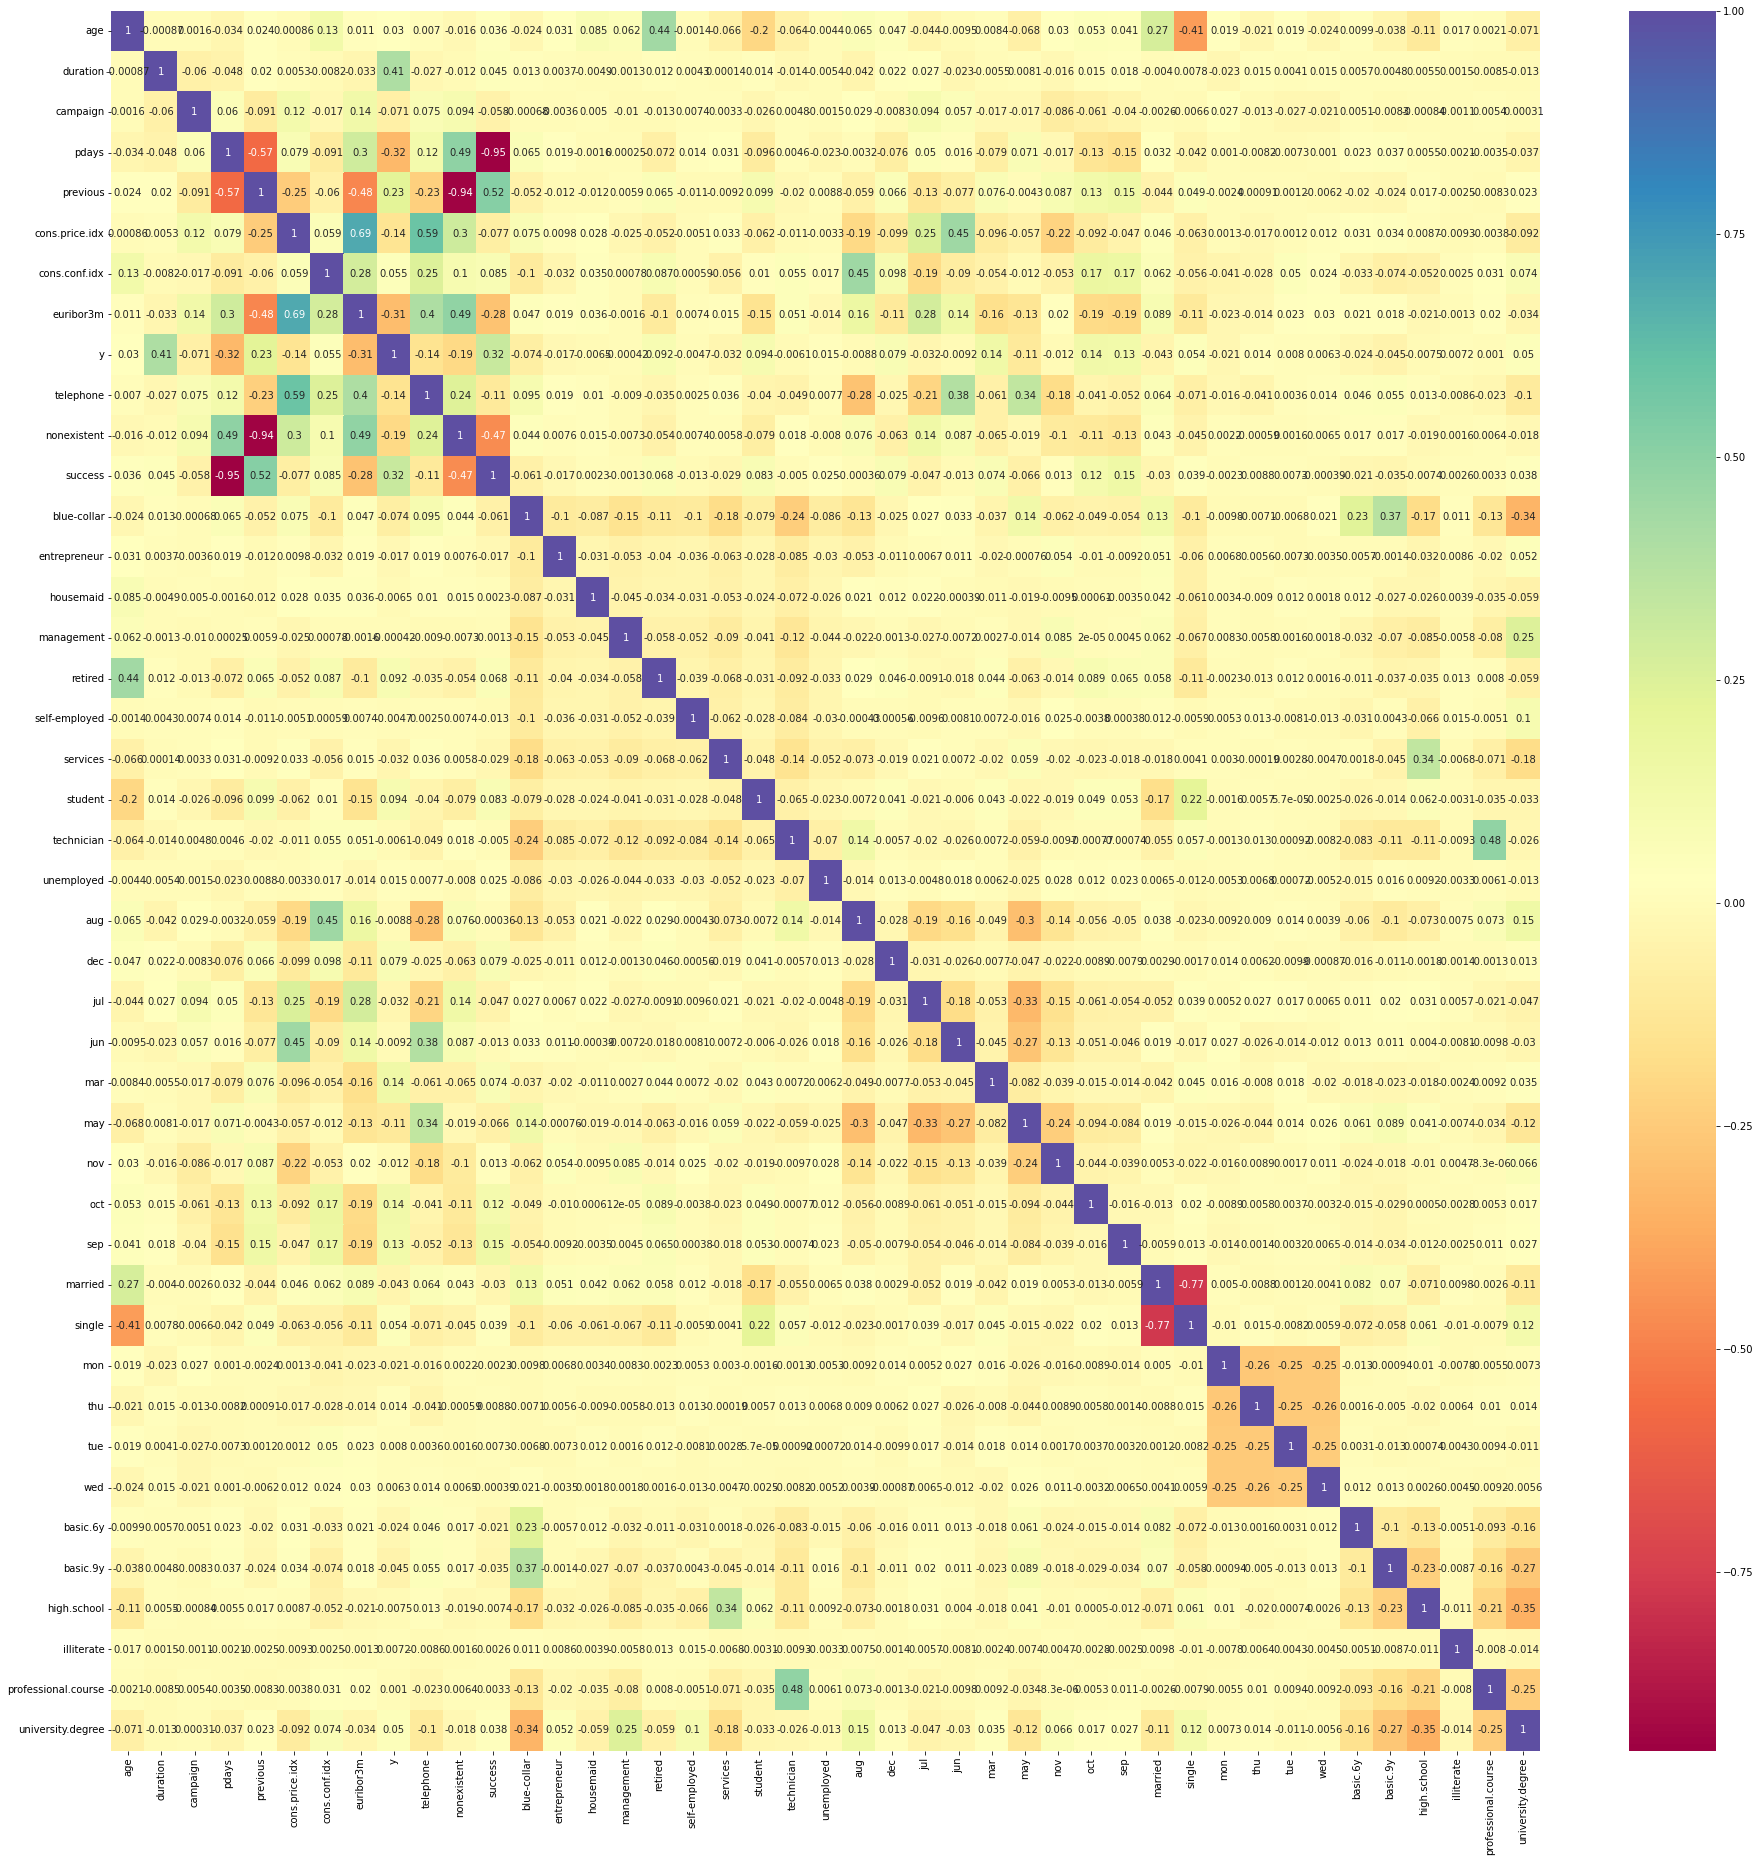

In [ ]:
plt.figure(figsize=(32, 32))
sns.heatmap(df.corr(), annot=True, cmap='Spectral')
plt.show()

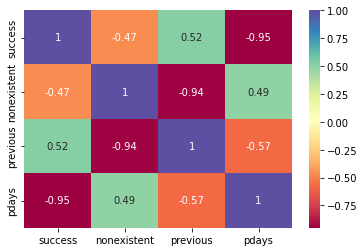

In [ ]:
sns.heatmap(df[['success', 'nonexistent', 'previous', 'pdays']].corr(), annot=True, cmap='Spectral')
plt.show()

Negative Correlation:
1. Previous v/s Nonexistent
2. Pdays v/s Success

In [ ]:
df.drop(['previous', 'pdays'], axis = 1, inplace = True)

In [ ]:
var_numerical = list(set(var_numerical) - set(['previous', 'pdays']))

In [ ]:
df.corr()['y']

age                    0.030399
duration               0.405274
campaign              -0.070968
cons.price.idx        -0.136211
cons.conf.idx          0.054878
euribor3m             -0.307771
y                      1.000000
telephone             -0.144773
nonexistent           -0.193507
success                0.316269
blue-collar           -0.074423
entrepreneur          -0.016644
housemaid             -0.006505
management            -0.000419
retired                0.092221
self-employed         -0.004663
services              -0.032301
student                0.093955
technician            -0.006149
unemployed             0.014752
aug                   -0.008813
dec                    0.079303
jul                   -0.032230
jun                   -0.009182
mar                    0.144014
may                   -0.108271
nov                   -0.011796
oct                    0.137366
sep                    0.126067
married               -0.043398
single                 0.054133
mon     

##standarization

In [ ]:
std_list = var_numerical 

def standartization(x):
    x_std = x.copy(deep=True)
    for column in std_list:
        x_std[column] = (x_std[column] - x_std[column].mean()) / x_std[column].std() 
    return x_std

df= standartization(df)
df.head()

,age,duration,campaign,cons.price.idx,cons.conf.idx,euribor3m,y,telephone,nonexistent,success,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,aug,dec,jul,jun,mar,may,nov,oct,sep,married,single,mon,thu,tue,wed,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree
0,1.533016,0.010471,-0.753573,0.722714,0.886436,0.712451,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,1.628973,-0.421495,-0.753573,0.722714,0.886436,0.712451,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,-0.290182,-0.124518,-0.753573,0.722714,0.886436,0.712451,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,-0.002309,-0.413782,-0.753573,0.722714,0.886436,0.712451,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,1.533016,0.187886,-0.753573,0.722714,0.886436,0.712451,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


##detect outliers

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

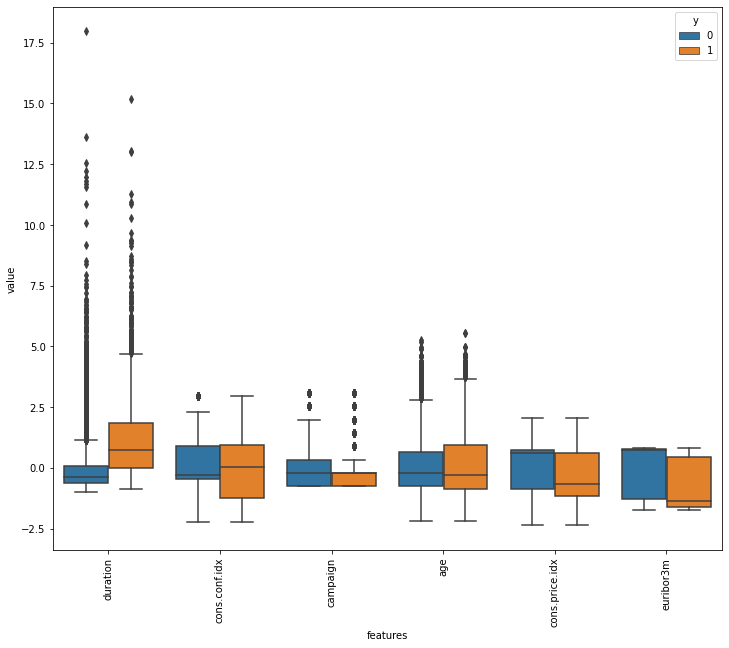

In [ ]:
#detect the outliers through box plots 

df_melt = pd.melt(frame= df, id_vars='y',
                  value_vars=var_numerical,
                  var_name='features',
                  value_name='value', 
                  col_level=None)
# Box plot
plt.figure(figsize=(12, 10))
sns.boxplot(x='features', y='value', hue='y', data=df_melt)
plt.xticks(rotation=90)

##get the inter-quartile range

In [ ]:
# Diciding upper and lower bound 
ap_list = var_numerical
df_ap = pd.DataFrame(index=['lower_bound', 'upper_bound'])

for i in ap_list:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    
    lowr_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df_ap[i] = [lowr_bound, upper_bound]
df_ap

,duration,cons.conf.idx,campaign,age,cons.price.idx,euribor3m
lower_bound,-1.858170,-2.516617,-2.395544,-2.929021,-3.246431,-4.441063
upper_bound,1.489572,2.928267,1.983045,2.828446,3.104201,3.900498


##remove the outliers

In [ ]:
# remove the outliers 
outlier_filter = ((df["duration"]>df_ap['duration'][1]) |(df["duration"]<df_ap['duration'][0])|
                  (df["cons.conf.idx"]>df_ap['cons.conf.idx'][1]) |(df["cons.conf.idx"]<df_ap['cons.conf.idx'][0])|
                  (df["campaign"]>df_ap['campaign'][1]) |(df["campaign"]<df_ap['campaign'][0])|
                  (df["cons.price.idx"]>df_ap['cons.price.idx'][1]) |(df["cons.price.idx"]<df_ap['cons.price.idx'][0])|
                  (df["euribor3m"]>df_ap['euribor3m'][1]) |(df["euribor3m"]<df_ap['euribor3m'][0])|
                  (df["age"]>df_ap['age'][1]) |(df["age"]<df_ap['age'][0]))
df = df[~outlier_filter]
df.shape

(35176, 41)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

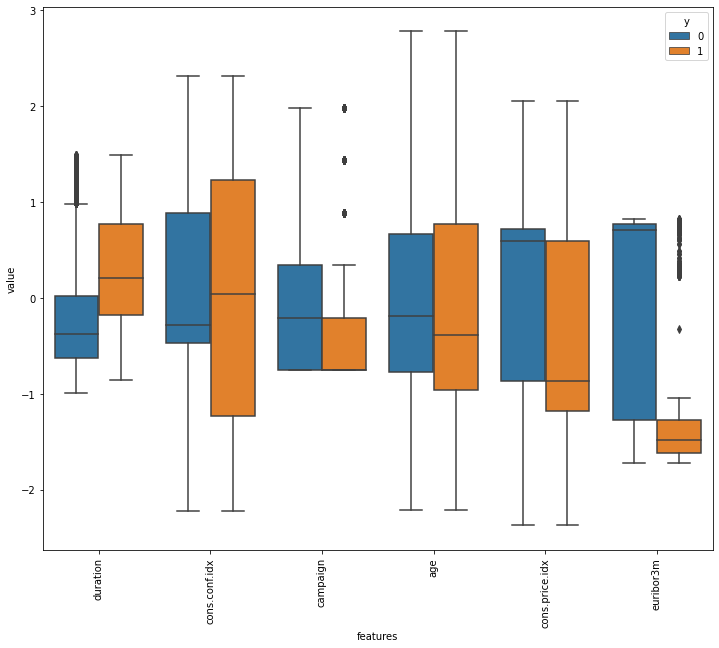

In [ ]:
# box plot after deleting the outliers 
df_melt = pd.melt(frame= df, id_vars='y',
                  value_vars=var_numerical,
                  var_name='features',
                  value_name='value', 
                  col_level=None)
# Box plot
plt.figure(figsize=(12, 10))
sns.boxplot(x='features', y='value', hue='y', data=df_melt)
plt.xticks(rotation=90)

##split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(["y"], axis = 1).values
y = df["y"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

In [ ]:
X_train.shape

(28140, 40)

In [ ]:
skf = StratifiedKFold(n_splits=5)

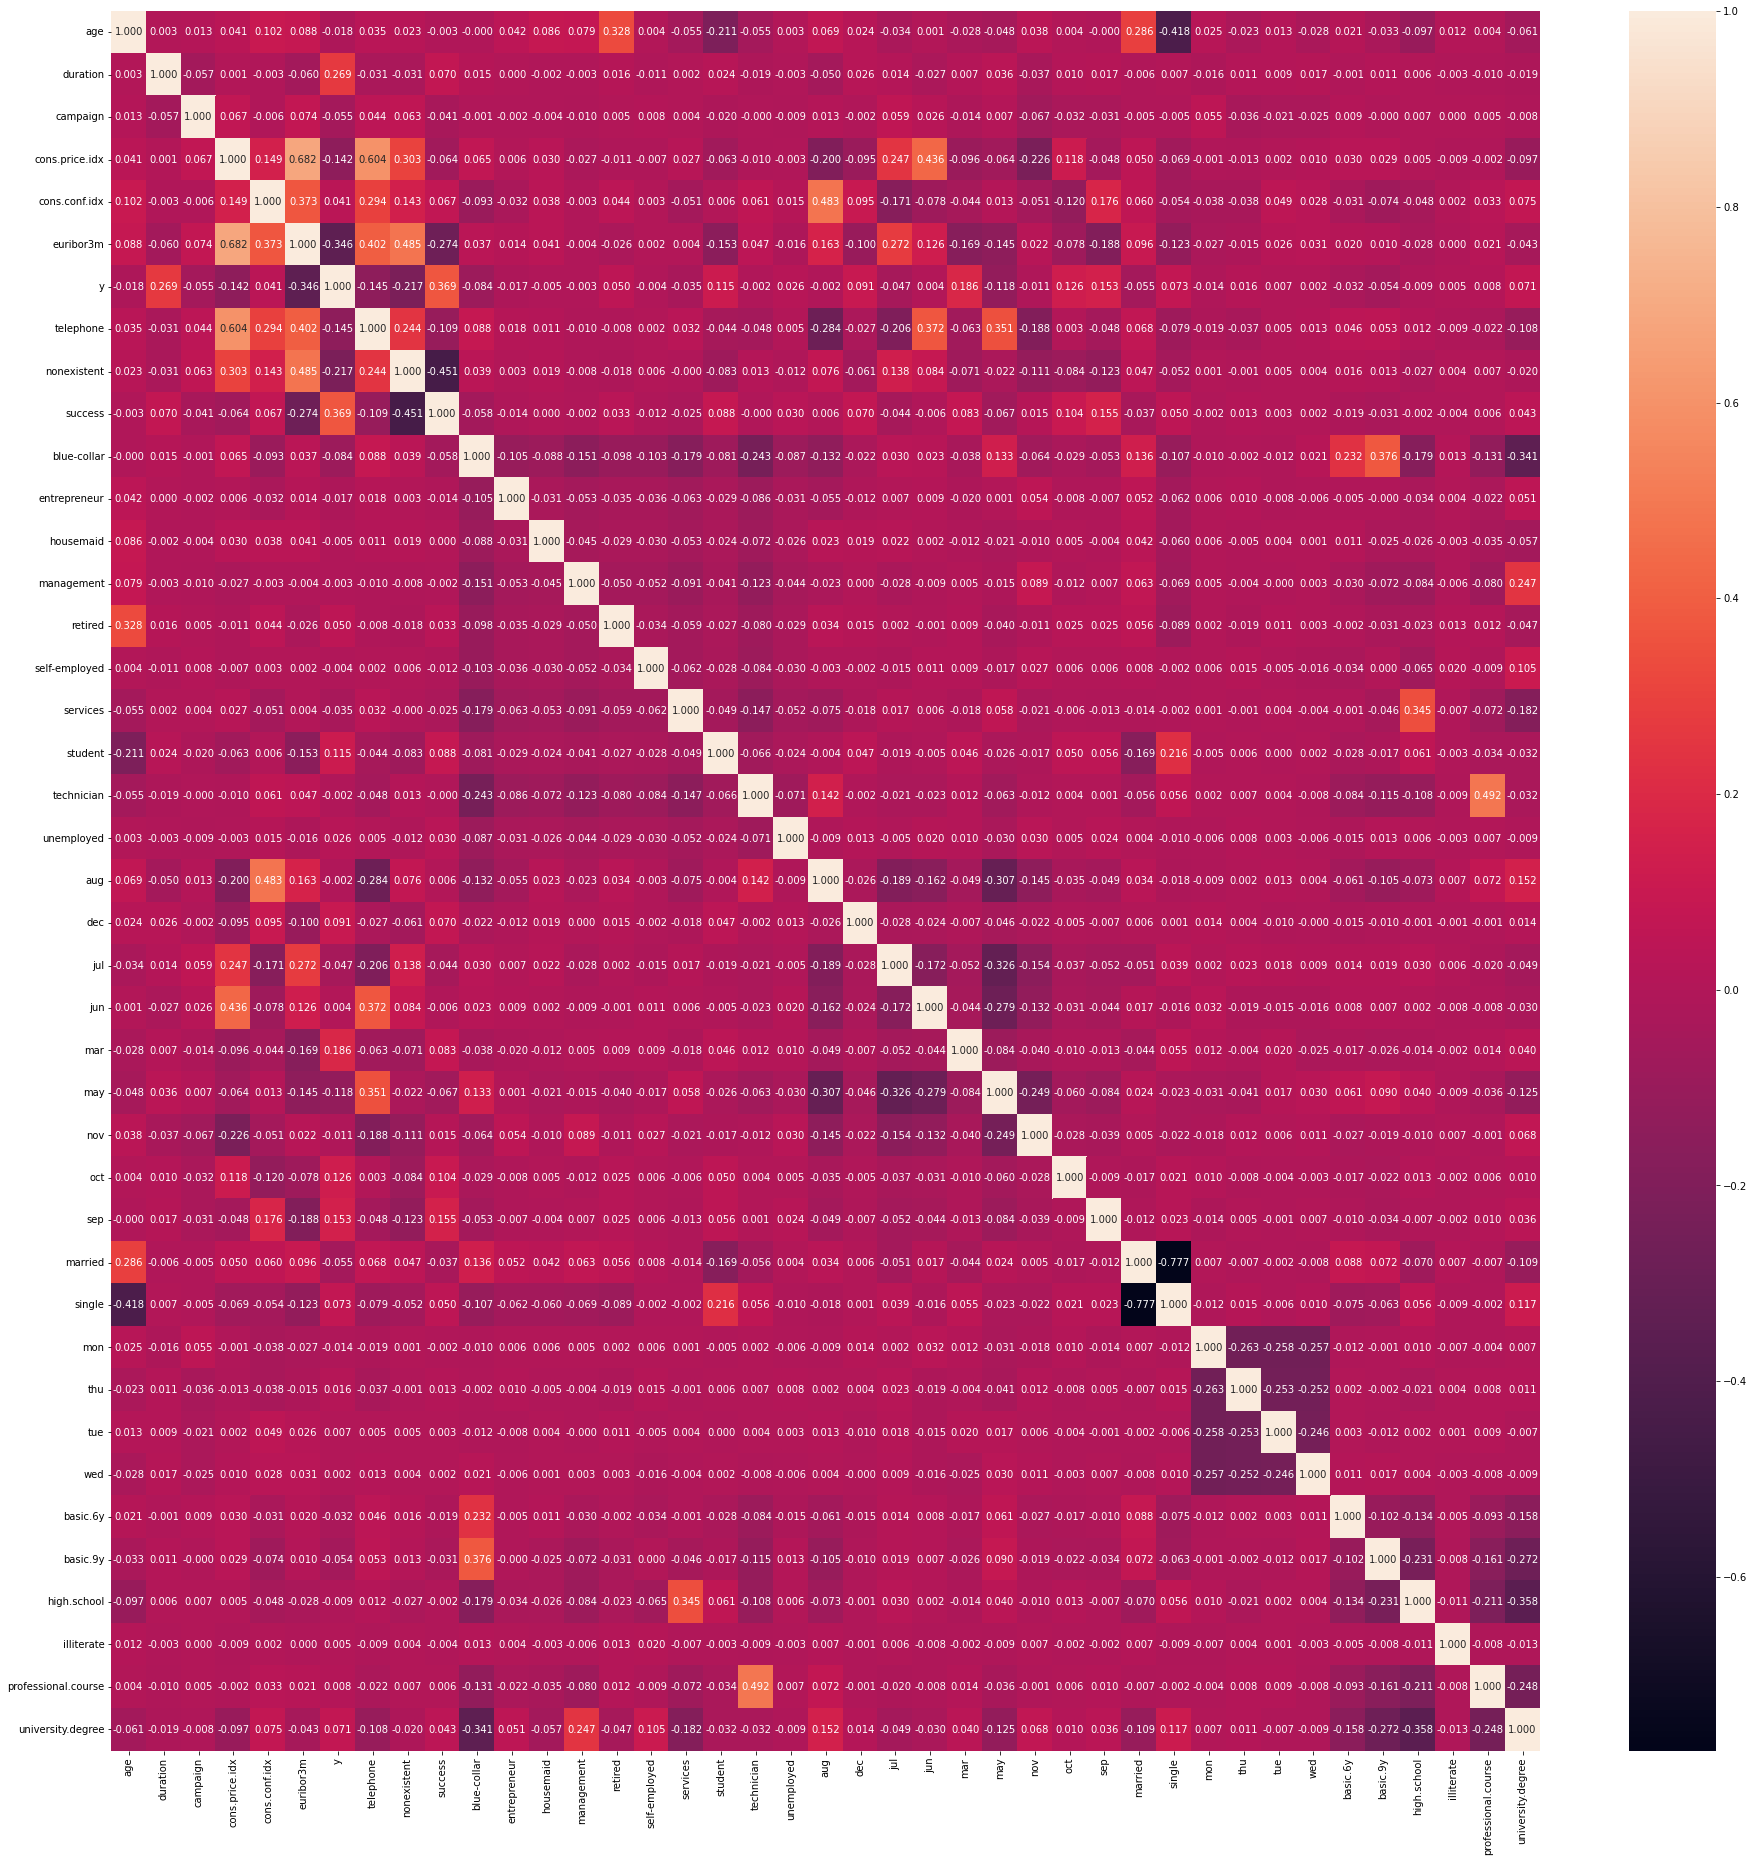

In [ ]:
# get the correlation of tbetween cardiovascular disease and each risk factor after preprocessing
plt.figure(figsize=(32, 32))
sns.heatmap(df.corr(), annot=True, fmt='.3f')

#logistic regression

##logistic regression without Stratified KFold cross validation

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.9381750994883457


##logistic regression with Stratified KFold cross validation

In [ ]:
training_acc = cross_val_score(model, X_train, y_train, cv=skf)

###test this model

In [ ]:
training_acc.max()

0.9401208244491827

In [ ]:
training_acc.min()

0.9326581378820185

In [ ]:
training_acc.mean()

0.9366027007818053

In [ ]:
print(model.score(X_test, y_test))

0.9381750994883457


#ANN model

##build the ANN model

In [ ]:
def create_ANN():
  model = Sequential()
  model.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' ,metrics = ['accuracy'])
  return model

##Train the ANN model without Stratified KFold cross validation

In [ ]:
model = create_ANN()
num_epochs = 50
history = model.fit(X_train ,
                    y_train ,
                    epochs= num_epochs,
                    validation_data=(X_test ,y_test))

Epoch 1/50
880/880 [==============================] - 5s 4ms/step - loss: 0.2143 - accuracy: 0.9183 - val_loss: 0.1584 - val_accuracy: 0.9237
Epoch 2/50
880/880 [==============================] - 4s 4ms/step - loss: 0.1700 - accuracy: 0.9241 - val_loss: 0.1514 - val_accuracy: 0.9386
Epoch 3/50
880/880 [==============================] - 3s 4ms/step - loss: 0.1640 - accuracy: 0.9302 - val_loss: 0.1507 - val_accuracy: 0.9359
Epoch 4/50
880/880 [==============================] - 3s 4ms/step - loss: 0.1596 - accuracy: 0.9329 - val_loss: 0.1471 - val_accuracy: 0.9407
Epoch 5/50
880/880 [==============================] - 3s 4ms/step - loss: 0.1586 - accuracy: 0.9349 - val_loss: 0.1467 - val_accuracy: 0.9382
Epoch 6/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1560 - accuracy: 0.9349 - val_loss: 0.1464 - val_accuracy: 0.9373
Epoch 7/50
880/880 [==============================] - 3s 4ms/step - loss: 0.1540 - accuracy: 0.9357 - val_loss: 0.1451 - val_accuracy: 0.9386
Epoch 

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: {:3.3f} and loss {:3.3f}'.format(acc ,loss))

Test Accuracy: 0.935 and loss 0.154


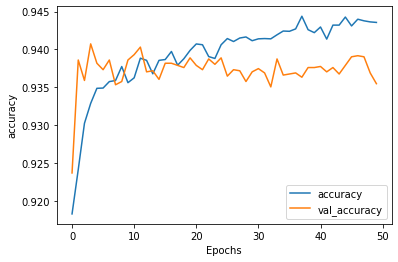

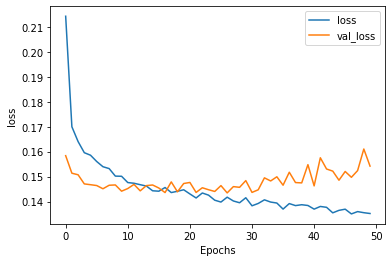

In [ ]:
def plot_ANN_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_ANN_graphs(history, "accuracy")
print()
plot_ANN_graphs(history, "loss")

In [ ]:
def plot_validation(pred, y):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y, pred)
  auc_keras = auc(fpr_keras, tpr_keras)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  print()
  
  conf_matrix = confusion_matrix(y, np.round(abs(pred)))
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()
  

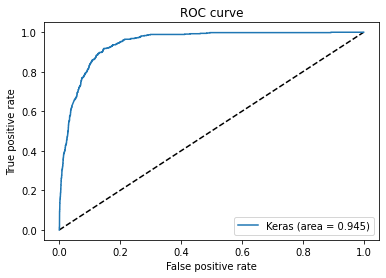

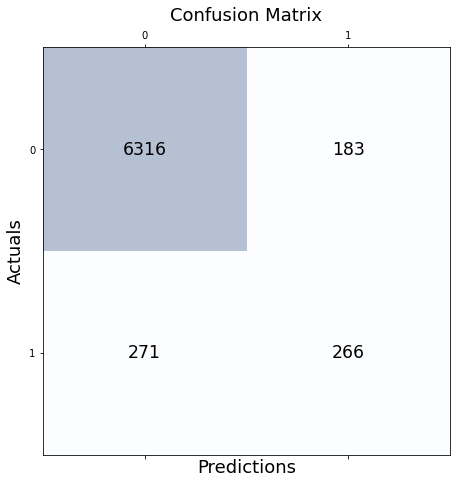

In [ ]:
pred = model.predict(X_test)
plot_validation(pred, y_test)

##Train the ANN model with Stratified KFold cross validation

In [ ]:
#rebuild the model
model = create_ANN()

Epoch 1/5
26/26 [==============================] - 2s 21ms/step - loss: 0.6438 - accuracy: 0.6685 - val_loss: 0.4618 - val_accuracy: 0.9222
Epoch 2/5
26/26 [==============================] - 0s 14ms/step - loss: 0.3408 - accuracy: 0.9220 - val_loss: 0.2591 - val_accuracy: 0.9222
Epoch 3/5
26/26 [==============================] - 0s 13ms/step - loss: 0.2806 - accuracy: 0.9220 - val_loss: 0.2320 - val_accuracy: 0.9222
Epoch 4/5
26/26 [==============================] - 0s 13ms/step - loss: 0.2462 - accuracy: 0.9220 - val_loss: 0.2045 - val_accuracy: 0.9222
Epoch 5/5
26/26 [==============================] - 0s 13ms/step - loss: 0.2110 - accuracy: 0.9220 - val_loss: 0.1787 - val_accuracy: 0.9222

result of fold # 1


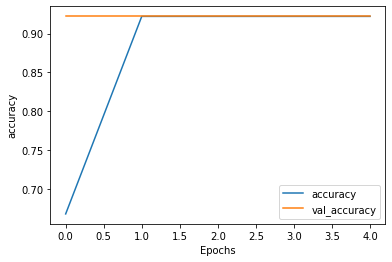

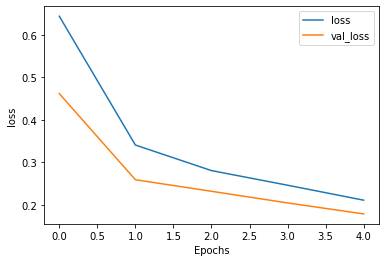


Epoch 1/5
26/26 [==============================] - 0s 15ms/step - loss: 0.1929 - accuracy: 0.9220 - val_loss: 0.1649 - val_accuracy: 0.9220
Epoch 2/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1787 - accuracy: 0.9220 - val_loss: 0.1610 - val_accuracy: 0.9220
Epoch 3/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1742 - accuracy: 0.9220 - val_loss: 0.1583 - val_accuracy: 0.9220
Epoch 4/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1695 - accuracy: 0.9220 - val_loss: 0.1580 - val_accuracy: 0.9220
Epoch 5/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1682 - accuracy: 0.9220 - val_loss: 0.1559 - val_accuracy: 0.9220

result of fold # 2


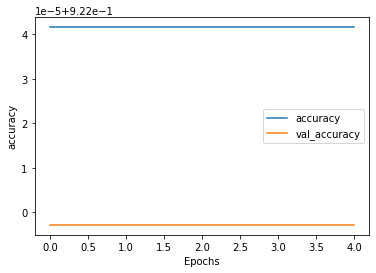

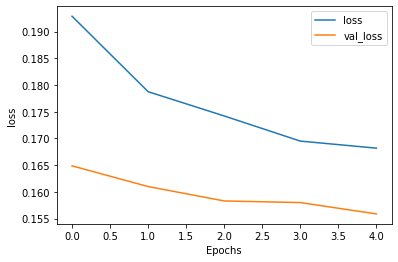


Epoch 1/5
26/26 [==============================] - 0s 14ms/step - loss: 0.1644 - accuracy: 0.9222 - val_loss: 0.1563 - val_accuracy: 0.9220
Epoch 2/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1635 - accuracy: 0.9222 - val_loss: 0.1564 - val_accuracy: 0.9220
Epoch 3/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1634 - accuracy: 0.9224 - val_loss: 0.1549 - val_accuracy: 0.9220
Epoch 4/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1601 - accuracy: 0.9220 - val_loss: 0.1555 - val_accuracy: 0.9220
Epoch 5/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1611 - accuracy: 0.9220 - val_loss: 0.1545 - val_accuracy: 0.9220

result of fold # 3


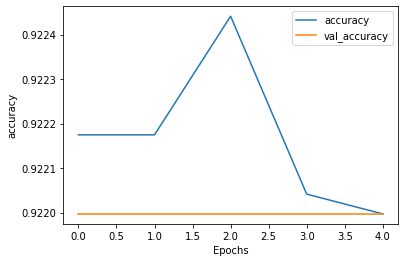

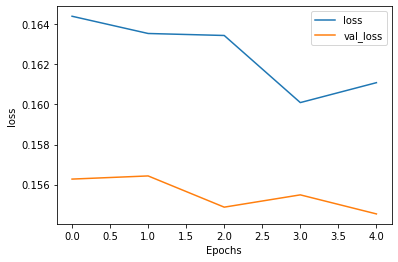


Epoch 1/5
26/26 [==============================] - 0s 14ms/step - loss: 0.1613 - accuracy: 0.9224 - val_loss: 0.1453 - val_accuracy: 0.9220
Epoch 2/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1596 - accuracy: 0.9239 - val_loss: 0.1452 - val_accuracy: 0.9220
Epoch 3/5
26/26 [==============================] - 0s 13ms/step - loss: 0.1609 - accuracy: 0.9246 - val_loss: 0.1455 - val_accuracy: 0.9220
Epoch 4/5
26/26 [==============================] - 0s 15ms/step - loss: 0.1582 - accuracy: 0.9241 - val_loss: 0.1450 - val_accuracy: 0.9220
Epoch 5/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1584 - accuracy: 0.9244 - val_loss: 0.1449 - val_accuracy: 0.9220

result of fold # 4


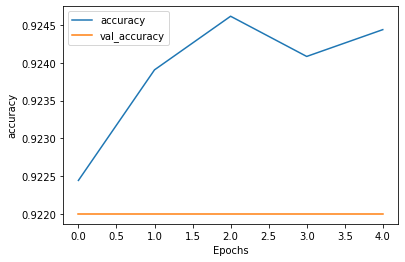

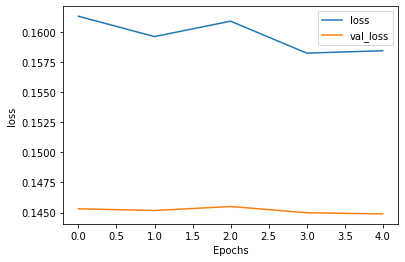


Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 0.1554 - accuracy: 0.9240 - val_loss: 0.1540 - val_accuracy: 0.9220
Epoch 2/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1546 - accuracy: 0.9262 - val_loss: 0.1541 - val_accuracy: 0.9325
Epoch 3/5
26/26 [==============================] - 0s 12ms/step - loss: 0.1530 - accuracy: 0.9271 - val_loss: 0.1546 - val_accuracy: 0.9318
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 0.1551 - accuracy: 0.9276 - val_loss: 0.1544 - val_accuracy: 0.9330
Epoch 5/5
26/26 [==============================] - 1s 28ms/step - loss: 0.1551 - accuracy: 0.9273 - val_loss: 0.1560 - val_accuracy: 0.9327

result of fold # 5


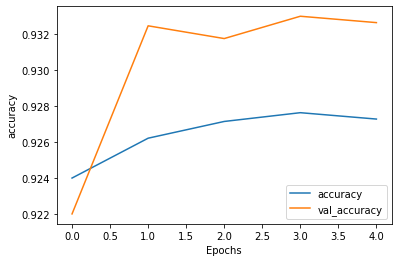

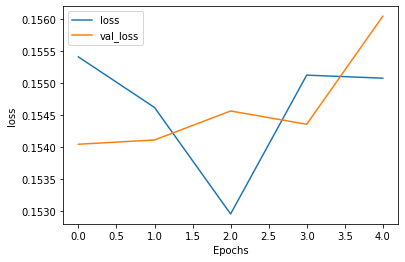

In [ ]:
acc = []
loss = []
num_epochs = 5
fold = 1
for train_indices, test_indices in skf.split(X_train, y_train):
    history = model.fit(X_train[train_indices] ,
                        y_train[train_indices] ,
                        epochs= num_epochs ,
                        batch_size= 880,
                        validation_data=(X_train[test_indices] ,y_train[test_indices]))
    
    loss_value, acc_value = model.evaluate(X_train[test_indices] ,y_train[test_indices], verbose=0)
    acc.append(acc_value)
    loss.append(loss_value)
    print()
    print("result of fold #", fold)
    fold += 1
    plot_ANN_graphs(history, "accuracy")
    print()
    plot_ANN_graphs(history, "loss")
    print()

In [ ]:
print('Test max Accuracy: {:3.3f} and its loss {:3.3f}'.format(max(acc) ,loss[acc.index(max(acc))]))

Test max Accuracy: 0.933 and its loss 0.156


In [ ]:
print('Test min Accuracy: {:3.3f} and its loss {:3.3f}'.format(min(acc) ,loss[acc.index(min(acc))]))

Test min Accuracy: 0.922 and its loss 0.156


In [ ]:

print('Test mean Accuracy: {:3.3f} and mean loss {:3.3f}'.format(mean(acc) ,mean(loss)))

Test mean Accuracy: 0.924 and mean loss 0.158


In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: {:3.3f} and loss {:3.3f}'.format(acc ,loss))

Test Accuracy: 0.934 and loss 0.151


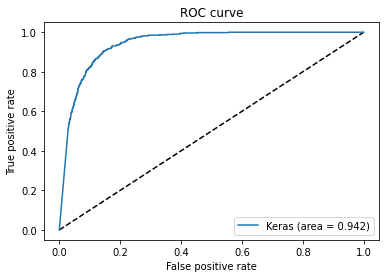

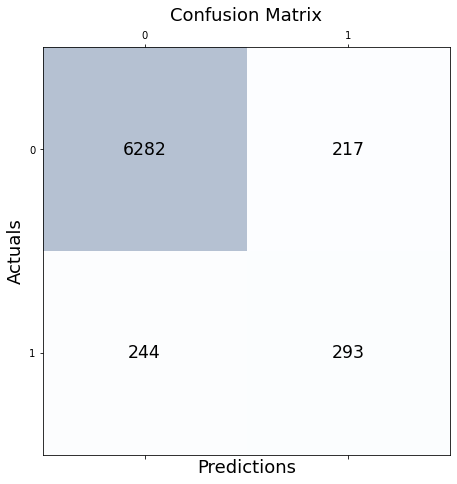

In [ ]:
pred = model.predict(X_test)
plot_validation(pred, y_test)

#SVM

##SVM without cross validation



In [ ]:
# create classifier
svc = SVC(kernel='linear')

In [ ]:
# train model
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
#Evaluating the Model
y_pred = svc.predict(X_test)#Predict the response for test dataset
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9313530415008527


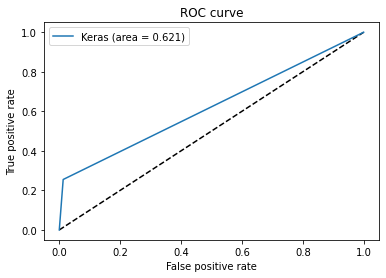

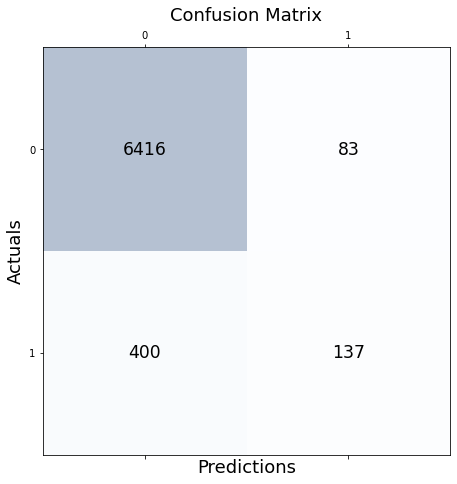

In [ ]:
pred = svc.predict(X_test)
plot_validation(pred, y_test)

##SVM with cross validation

In [ ]:
# create classifier
all_svc = []
all_acc = []

In [ ]:
for train_indices, test_indices in skf.split(X_train, y_train):
  svc = SVC(kernel='linear')
  svc.fit(X_train[train_indices], y_train[train_indices])
  y_pred = svc.predict(X_train[test_indices])#Predict the response for test dataset
  acc = metrics.accuracy_score(y_train[test_indices], y_pred)
  print("Accuracy:",acc)
  all_acc.append(acc)
  all_svc.append(svc)

Accuracy: 0.9280383795309168
Accuracy: 0.9308813077469794
Accuracy: 0.9291044776119403
Accuracy: 0.9308813077469794
Accuracy: 0.9317697228144989


In [ ]:
max(all_acc)

0.9317697228144989

In [ ]:
min(all_acc)

0.9280383795309168

In [ ]:
mean(all_acc)

0.930135039090263

In [ ]:
best_svc = all_svc[all_acc.index(max(all_acc))]

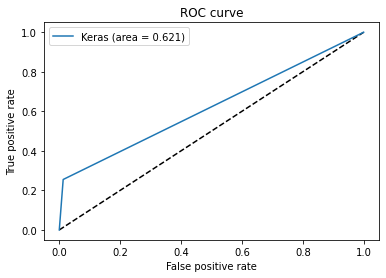

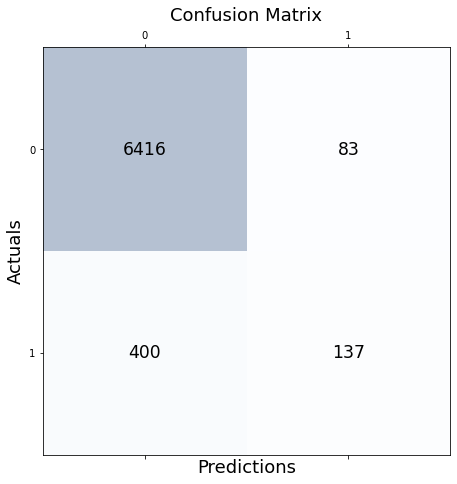

In [ ]:
pred = best_svc.predict(X_test)
plot_validation(pred, y_test)